# Random Forest Model Training with Ablation Study
## GoBest Cab - Dangerous Driving Behaviour Detection

This notebook implements Random Forest classifier for detecting dangerous driving behaviour with:
- MLflow experiment tracking
- Class imbalance handling
- Regularization techniques to prevent overfitting
- Comprehensive ablation study

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. MLflow Setup

In [2]:
# MLflow Configuration
# Set tracking URI to the MLflow server
mlflow.set_tracking_uri("http://localhost:5000")

# Define experiment naming convention: {model_name}_{dataset}_{reg/noreg}
EXPERIMENT_BASE_NAME = "RandomForest_balanced_smote"

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Tracking URI: http://localhost:5000


## 2. Load Data

In [3]:
# Load the main dataset
DATA_PATH = "../../Datasets/ca2_balanced_smote/balanced_smote.csv"
CLASS_WEIGHTS_PATH = "../../Datasets/ca2_balanced_smote/class_weights.json"

df = pd.read_csv(DATA_PATH)

# Load class weights from JSON
with open(CLASS_WEIGHTS_PATH, 'r') as f:
    class_weights_info = json.load(f)

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nClass weights info:")
print(json.dumps(class_weights_info, indent=2))

Dataset shape: (29988, 144)

Class distribution:
label
0    14994
1    14994
Name: count, dtype: int64

Class weights info:
{
  "class_0_weight": 0.665999733226624,
  "class_1_weight": 2.0060265166733626,
  "scale_pos_weight": 3.0120530333467253,
  "original_class_0": 14994,
  "original_class_1": 4978,
  "imbalance_ratio": 3.0120530333467257
}


In [4]:
# Prepare features and target
# IMPORTANT: Exclude bookingID and is_dangerous_trip - they are just references
columns_to_drop = ['bookingID', 'label']

# Check if is_dangerous_trip exists and drop it
if 'is_dangerous_trip' in df.columns:
    columns_to_drop.append('is_dangerous_trip')

# Also drop is_synthetic if it exists (it's a SMOTE indicator, not a feature)
if 'is_synthetic' in df.columns:
    columns_to_drop.append('is_synthetic')

X = df.drop(columns=columns_to_drop)
y = df['label']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist()[:10], "... and", len(X.columns)-10, "more")

Features shape: (29988, 141)
Target shape: (29988,)

Feature columns (141):
['vehicle_key', 'trip_duration_sec', 'total_distance_km', 'avg_gps_accuracy', 'harsh_acceleration_count', 'harsh_braking_count', 'sharp_turn_count', 'speeding_event_count', 'phone_distraction_count', 'avg_acceleration_magnitude'] ... and 131 more


## 3. Data Preprocessing

In [5]:
# Check for missing values and handle them
print("Missing values per column:")
missing = X.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    # Fill missing values with median (robust to outliers)
    X = X.fillna(X.median())
    print("\nMissing values filled with median.")
else:
    print("No missing values found.")

# Check for infinite values
inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
print(f"\nInfinite values count: {inf_count}")
if inf_count > 0:
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("Infinite values replaced with median.")

Missing values per column:
No missing values found.

Infinite values count: 0


In [6]:
# Train-test split with stratification to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Training set: 23990 samples
Test set: 5998 samples

Training class distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Test class distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [7]:
# Feature scaling using RobustScaler (less sensitive to outliers)
# Note: Random Forest doesn't require scaling, but keeping for consistency
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

print("Feature scaling completed using RobustScaler.")

Feature scaling completed using RobustScaler.


## 4. Class Imbalance Handling

In [8]:
# Set up class weights for handling imbalance
# For Random Forest, we use class_weight parameter
class_weight_dict = {
    0: class_weights_info.get('class_0_weight', 1.0),
    1: class_weights_info.get('class_1_weight', 3.0)
}

print(f"Class weight dictionary: {class_weight_dict}")

Class weight dictionary: {0: 0.665999733226624, 1: 2.0060265166733626}


## 5. Helper Functions

In [9]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Comprehensive model evaluation with all required metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba),
    }
    
    # Detect overfitting
    overfit_gap = metrics['train_f1'] - metrics['test_f1']
    metrics['overfit_gap'] = overfit_gap
    metrics['is_overfitting'] = overfit_gap > 0.05  # 5% gap threshold
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"\nAccuracy  - Train: {metrics['train_accuracy']:.4f} | Test: {metrics['test_accuracy']:.4f}")
    print(f"F1 Score  - Train: {metrics['train_f1']:.4f} | Test: {metrics['test_f1']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"\nOverfit Gap (Train F1 - Test F1): {overfit_gap:.4f}")
    if metrics['is_overfitting']:
        print("⚠️  WARNING: Model shows signs of overfitting!")
    else:
        print("✅ Model generalization looks good.")
    
    return metrics, y_test_pred, y_test_proba


def plot_confusion_matrix(y_test, y_pred, model_name="Model"):
    """
    Plot confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe (0)', 'Dangerous (1)'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    return fig


def plot_roc_curve(y_test, y_proba, model_name="Model"):
    """
    Plot ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} - ROC Curve')
    ax.legend(loc='lower right')
    plt.tight_layout()
    return fig


def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """
    Plot top N feature importances.
    """
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1][:top_n]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(top_n), importance[indices][::-1], align='center')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels([feature_names[i] for i in indices][::-1])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'{model_name} - Top {top_n} Feature Importances')
    plt.tight_layout()
    return fig


def plot_learning_history_rf(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Plot Random Forest learning history (F1 score vs number of trees).
    Uses staged predictions based on cumulative tree predictions.
    """
    from sklearn.ensemble import RandomForestClassifier
    
    n_estimators = model.n_estimators
    train_f1_scores = []
    test_f1_scores = []
    
    # Sample fewer points for efficiency
    step = max(1, n_estimators // 20)
    tree_counts = list(range(step, n_estimators + 1, step))
    if tree_counts[-1] != n_estimators:
        tree_counts.append(n_estimators)
    
    for n_trees in tree_counts:
        # Use predictions from first n_trees trees
        y_train_pred = np.zeros(len(y_train))
        y_test_pred = np.zeros(len(y_test))
        
        for i in range(n_trees):
            y_train_pred += model.estimators_[i].predict(X_train)
            y_test_pred += model.estimators_[i].predict(X_test)
        
        # Majority vote
        y_train_pred = (y_train_pred / n_trees >= 0.5).astype(int)
        y_test_pred = (y_test_pred / n_trees >= 0.5).astype(int)
        
        train_f1_scores.append(f1_score(y_train, y_train_pred))
        test_f1_scores.append(f1_score(y_test, y_test_pred))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(tree_counts, train_f1_scores, 'b-', label='Train F1', linewidth=2)
    ax.plot(tree_counts, test_f1_scores, 'r-', label='Test F1', linewidth=2)
    
    ax.set_xlabel('Number of Trees')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'{model_name} - Learning History')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

## 6. Cross-Validation Setup

In [10]:
# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def perform_cross_validation(model, X, y, cv=cv):
    """
    Perform cross-validation and return scores.
    """
    scoring = ['f1', 'precision', 'recall', 'roc_auc', 'accuracy']
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    
    print("\nCross-Validation Results (5-fold):")
    print("-" * 50)
    for metric in scoring:
        train_scores = cv_results[f'train_{metric}']
        test_scores = cv_results[f'test_{metric}']
        print(f"{metric.upper():12} - Train: {train_scores.mean():.4f} (+/- {train_scores.std()*2:.4f}) | "
              f"Test: {test_scores.mean():.4f} (+/- {test_scores.std()*2:.4f})")
    
    return cv_results

---
## 7. Model Training WITHOUT Regularization
### Baseline Random Forest Model (High Complexity, No Regularization)

In [11]:
# Set experiment for no regularization
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_noreg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_noreg")

Experiment: RandomForest_balanced_smote_noreg


In [12]:
# Random Forest WITHOUT Regularization (baseline - likely to overfit)
rf_noreg = RandomForestClassifier(
    n_estimators=100,  # Reduced for faster training
    max_depth=None,  # Unlimited depth - prone to overfitting
    min_samples_split=2,  # Low value - prone to overfitting
    min_samples_leaf=1,  # Low value - prone to overfitting
    max_features='sqrt',  # Standard for classification
    max_leaf_nodes=200,  # Limited for faster training (still allows overfitting)
    min_impurity_decrease=0.0,  # No threshold
    bootstrap=True,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

print("Random Forest Model (No Regularization) Configuration:")
print(rf_noreg.get_params())

Random Forest Model (No Regularization) Configuration:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 200, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Training Random Forest without regularization...

Random Forest (No Regularization) Evaluation Results

Accuracy  - Train: 0.8452 | Test: 0.7793
F1 Score  - Train: 0.8391 | Test: 0.7694
Precision: 0.8053
Recall:    0.7366
ROC-AUC:   0.8604

Overfit Gap (Train F1 - Test F1): 0.0697
⚠️  WARNING: Model shows signs of overfitting!


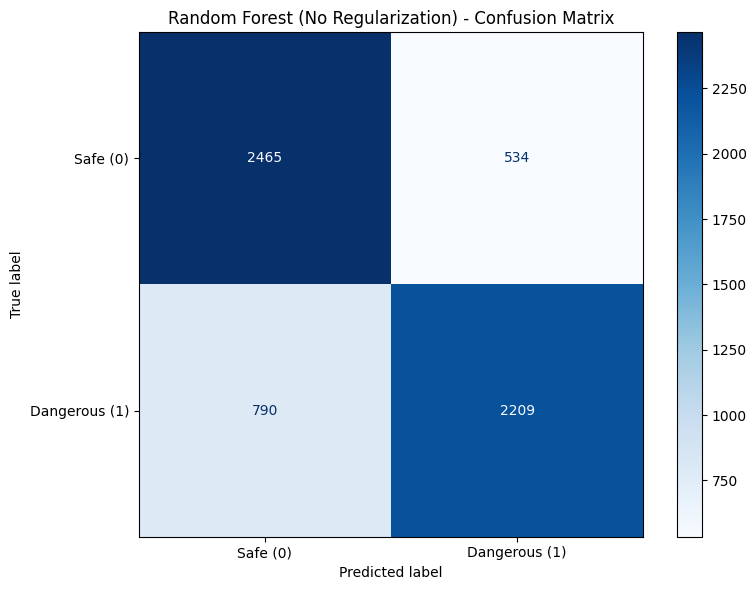

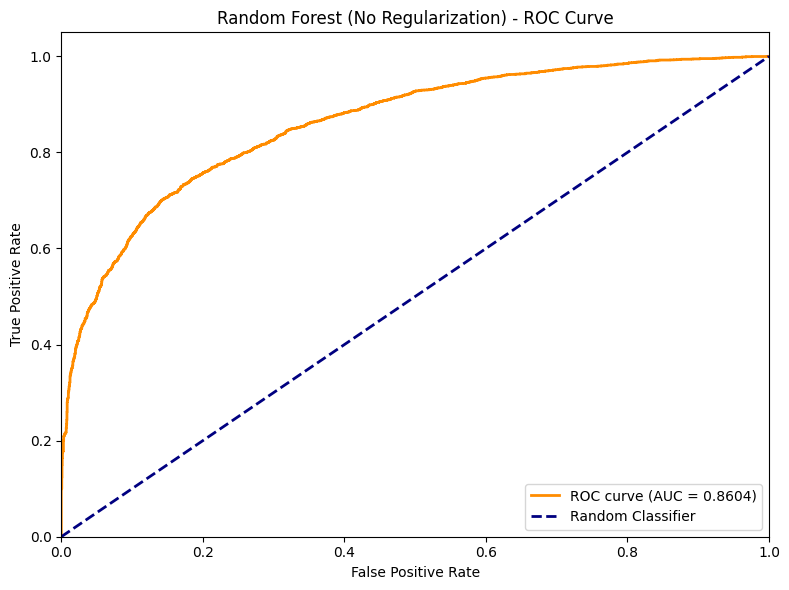


Generating learning history (this may take a moment)...


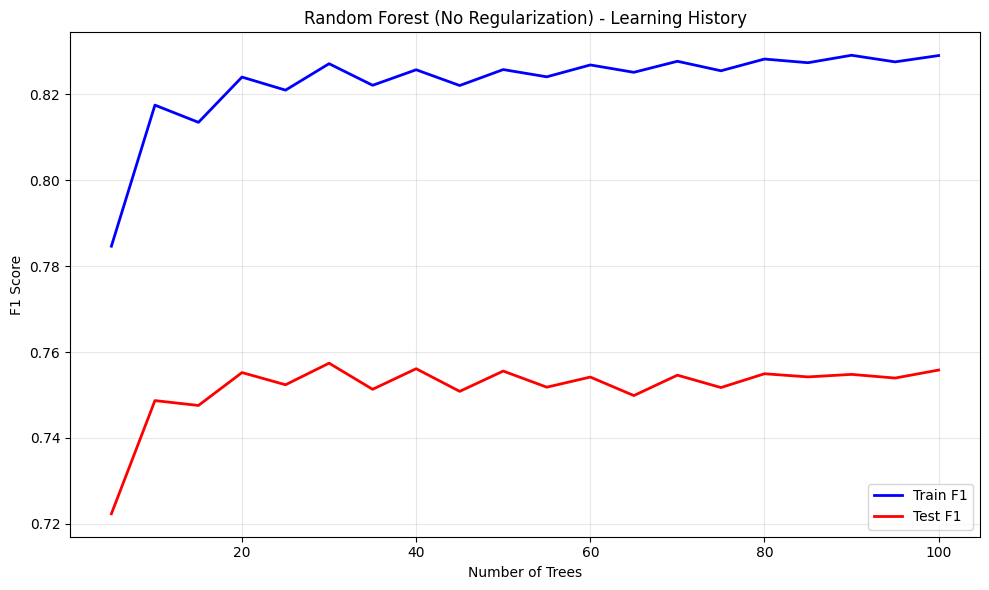

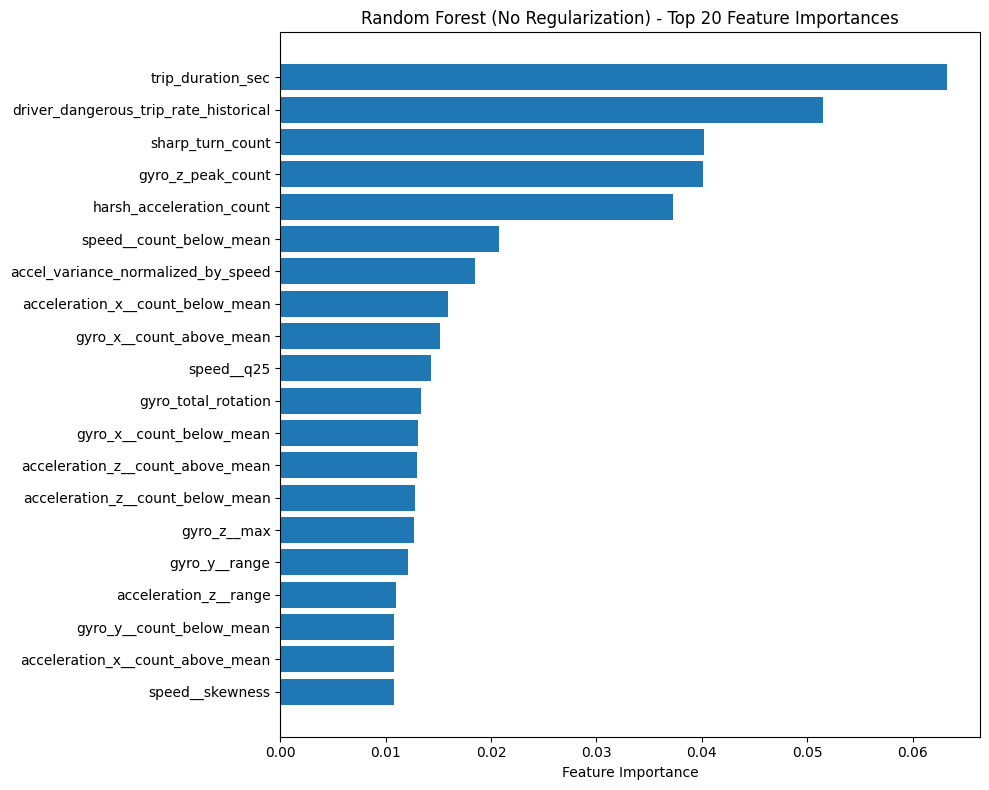

2026/01/31 17:48:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: b70b6a12a27445fcb3e44bd4ae049d71
🏃 View run RandomForest_NoReg_Baseline at: http://localhost:5000/#/experiments/9/runs/b70b6a12a27445fcb3e44bd4ae049d71
🧪 View experiment at: http://localhost:5000/#/experiments/9


In [13]:
# Train the model without regularization
with mlflow.start_run(run_name="RandomForest_NoReg_Baseline"):
    # Log parameters
    mlflow.log_params(rf_noreg.get_params())
    mlflow.log_param("regularization", "none")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model
    print("Training Random Forest without regularization...")
    rf_noreg.fit(X_train_scaled, y_train)
    
    # Evaluate
    metrics_noreg, y_pred_noreg, y_proba_noreg = evaluate_model(
        rf_noreg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="Random Forest (No Regularization)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_noreg['train_accuracy'],
        'test_accuracy': metrics_noreg['test_accuracy'],
        'train_f1': metrics_noreg['train_f1'],
        'test_f1': metrics_noreg['test_f1'],
        'precision': metrics_noreg['precision'],
        'recall': metrics_noreg['recall'],
        'roc_auc': metrics_noreg['roc_auc'],
        'overfit_gap': metrics_noreg['overfit_gap']
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_noreg, "Random Forest (No Regularization)")
    mlflow.log_figure(fig_cm, "confusion_matrix_noreg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_noreg, "Random Forest (No Regularization)")
    mlflow.log_figure(fig_roc, "roc_curve_noreg.png")
    plt.show()
    
    # Plot and log learning history (F1 vs number of trees)
    print("\nGenerating learning history (this may take a moment)...")
    fig_lh = plot_learning_history_rf(rf_noreg, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest (No Regularization)")
    mlflow.log_figure(fig_lh, "learning_history_noreg.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(rf_noreg, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="Random Forest (No Regularization)")
    mlflow.log_figure(fig_fi, "feature_importance_noreg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.sklearn.log_model(rf_noreg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [14]:
# Cross-validation for no-reg model
print("\n" + "="*60)
print("Cross-Validation for Random Forest (No Regularization)")
print("="*60)
cv_results_noreg = perform_cross_validation(rf_noreg, X_train_scaled, y_train)


Cross-Validation for Random Forest (No Regularization)

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 0.8524 (+/- 0.0038) | Test: 0.7659 (+/- 0.0050)
PRECISION    - Train: 0.8836 (+/- 0.0023) | Test: 0.7979 (+/- 0.0102)
RECALL       - Train: 0.8234 (+/- 0.0054) | Test: 0.7364 (+/- 0.0044)
ROC_AUC      - Train: 0.9363 (+/- 0.0012) | Test: 0.8568 (+/- 0.0057)
ACCURACY     - Train: 0.8575 (+/- 0.0033) | Test: 0.7749 (+/- 0.0059)


In [15]:
# Classification Report
print("\nClassification Report (No Regularization):")
print(classification_report(y_test, y_pred_noreg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (No Regularization):
               precision    recall  f1-score   support

     Safe (0)       0.76      0.82      0.79      2999
Dangerous (1)       0.81      0.74      0.77      2999

     accuracy                           0.78      5998
    macro avg       0.78      0.78      0.78      5998
 weighted avg       0.78      0.78      0.78      5998



---
## 8. Model Training WITH Regularization
### Random Forest with Regularization to Combat Overfitting

In [16]:
# Set experiment for regularized model
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_reg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_reg")

Experiment: RandomForest_balanced_smote_reg


In [17]:
# Random Forest WITH Regularization
rf_reg = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,  # Limit tree depth
    min_samples_split=10,  # Require more samples to split
    min_samples_leaf=5,  # Require more samples in leaf
    max_features='sqrt',  # Feature subsampling
    max_leaf_nodes=100,  # Limit number of leaf nodes
    min_impurity_decrease=0.001,  # Minimum impurity decrease for split
    bootstrap=True,
    oob_score=True,  # Out-of-bag score for validation
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

print("Random Forest Model (With Regularization) Configuration:")
print("\nRegularization techniques applied:")
print("- Limited max_depth: None -> 15")
print("- Increased min_samples_split: 2 -> 10")
print("- Increased min_samples_leaf: 1 -> 5")
print("- Limited max_leaf_nodes: None -> 100")
print("- Added min_impurity_decrease: 0 -> 0.001")
print("- Enabled OOB score for validation")

Random Forest Model (With Regularization) Configuration:

Regularization techniques applied:
- Limited max_depth: None -> 15
- Increased min_samples_split: 2 -> 10
- Increased min_samples_leaf: 1 -> 5
- Limited max_leaf_nodes: None -> 100
- Added min_impurity_decrease: 0 -> 0.001
- Enabled OOB score for validation


Training Random Forest with regularization...

Random Forest (Regularized) Evaluation Results

Accuracy  - Train: 0.7338 | Test: 0.7206
F1 Score  - Train: 0.7216 | Test: 0.7054
Precision: 0.7458
Recall:    0.6692
ROC-AUC:   0.8014

Overfit Gap (Train F1 - Test F1): 0.0161
✅ Model generalization looks good.

Out-of-Bag Score: 0.7226


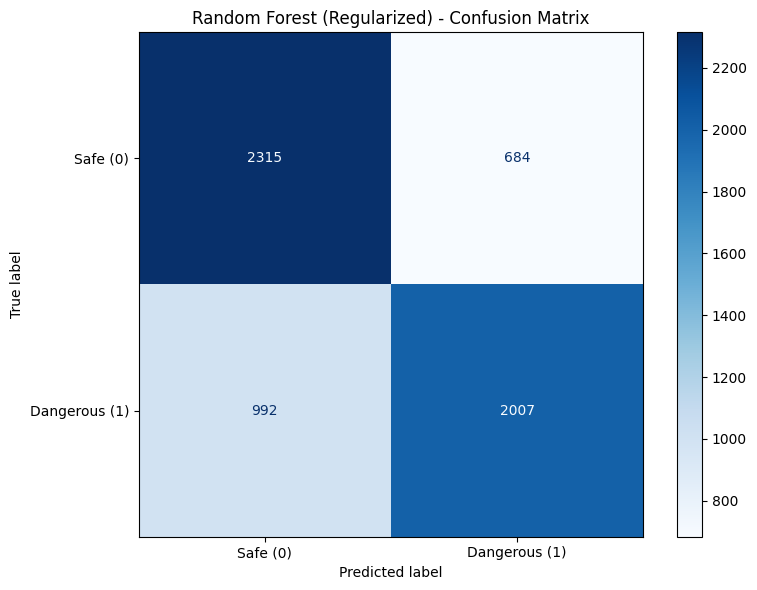

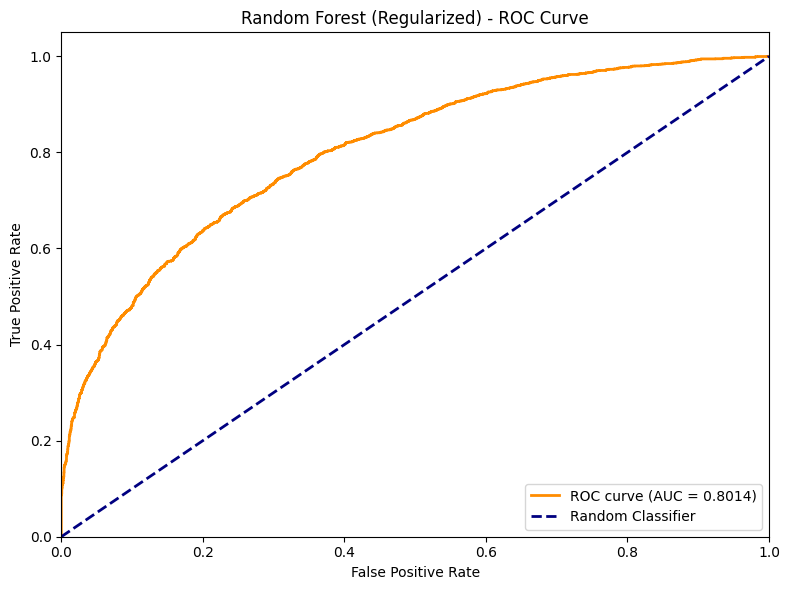


Generating learning history (this may take a moment)...


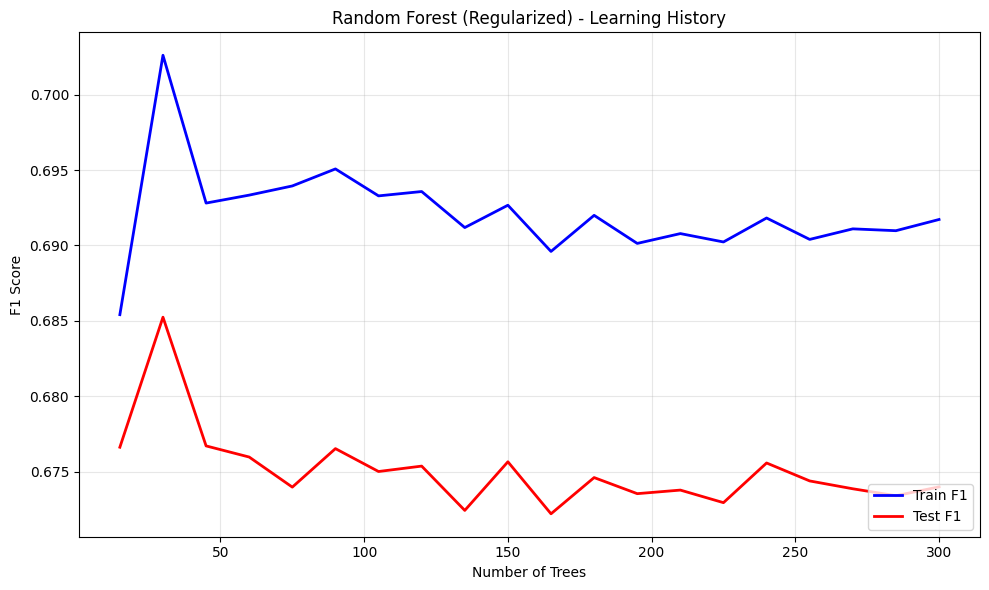

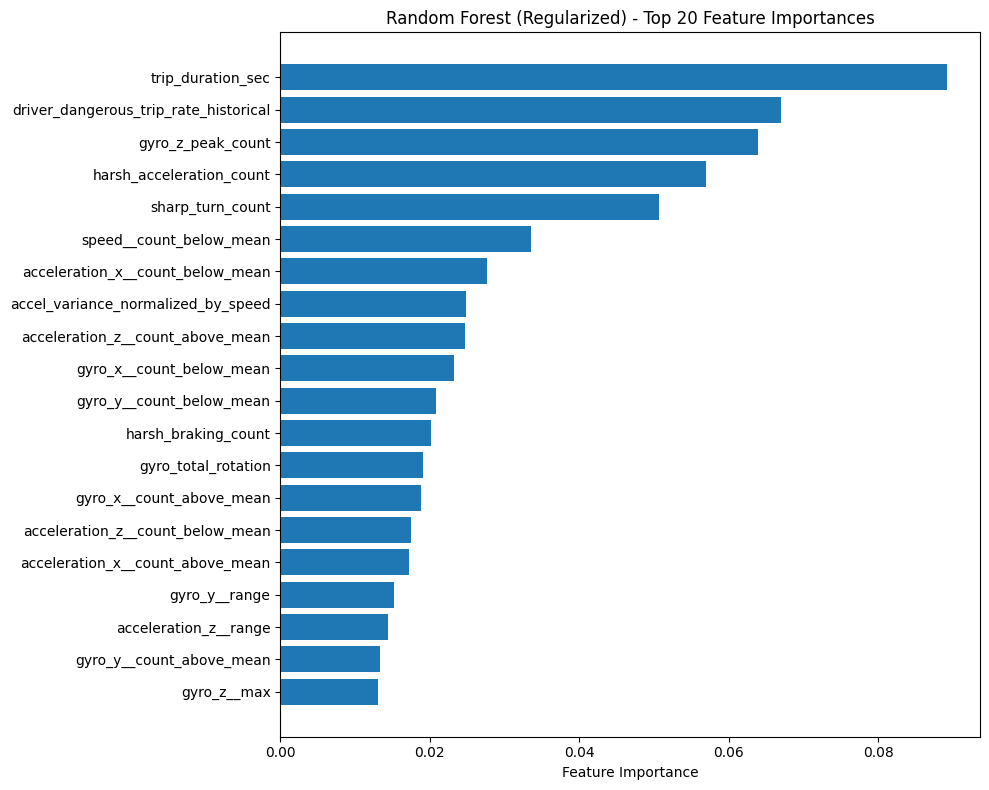

2026/01/31 17:49:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: 6ab68041cf2242d89bdd3a7c6d0a3a36
🏃 View run RandomForest_Regularized at: http://localhost:5000/#/experiments/10/runs/6ab68041cf2242d89bdd3a7c6d0a3a36
🧪 View experiment at: http://localhost:5000/#/experiments/10


In [18]:
# Train the model with regularization
with mlflow.start_run(run_name="RandomForest_Regularized"):
    # Log parameters
    mlflow.log_params(rf_reg.get_params())
    mlflow.log_param("regularization", "depth_samples_leaves")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model
    print("Training Random Forest with regularization...")
    rf_reg.fit(X_train_scaled, y_train)
    
    # Evaluate
    metrics_reg, y_pred_reg, y_proba_reg = evaluate_model(
        rf_reg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="Random Forest (Regularized)"
    )
    
    # Log OOB score
    print(f"\nOut-of-Bag Score: {rf_reg.oob_score_:.4f}")
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_reg['train_accuracy'],
        'test_accuracy': metrics_reg['test_accuracy'],
        'train_f1': metrics_reg['train_f1'],
        'test_f1': metrics_reg['test_f1'],
        'precision': metrics_reg['precision'],
        'recall': metrics_reg['recall'],
        'roc_auc': metrics_reg['roc_auc'],
        'overfit_gap': metrics_reg['overfit_gap'],
        'oob_score': rf_reg.oob_score_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_reg, "Random Forest (Regularized)")
    mlflow.log_figure(fig_cm, "confusion_matrix_reg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_reg, "Random Forest (Regularized)")
    mlflow.log_figure(fig_roc, "roc_curve_reg.png")
    plt.show()
    
    # Plot and log learning history (F1 vs number of trees)
    print("\nGenerating learning history (this may take a moment)...")
    fig_lh = plot_learning_history_rf(rf_reg, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest (Regularized)")
    mlflow.log_figure(fig_lh, "learning_history_reg.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(rf_reg, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="Random Forest (Regularized)")
    mlflow.log_figure(fig_fi, "feature_importance_reg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.sklearn.log_model(rf_reg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [19]:
# Cross-validation for regularized model
print("\n" + "="*60)
print("Cross-Validation for Random Forest (Regularized)")
print("="*60)
cv_results_reg = perform_cross_validation(rf_reg, X_train_scaled, y_train)


Cross-Validation for Random Forest (Regularized)

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 0.7252 (+/- 0.0077) | Test: 0.7099 (+/- 0.0129)
PRECISION    - Train: 0.7616 (+/- 0.0064) | Test: 0.7461 (+/- 0.0171)
RECALL       - Train: 0.6922 (+/- 0.0113) | Test: 0.6770 (+/- 0.0148)
ROC_AUC      - Train: 0.8185 (+/- 0.0026) | Test: 0.8025 (+/- 0.0100)
ACCURACY     - Train: 0.7377 (+/- 0.0063) | Test: 0.7233 (+/- 0.0129)


In [20]:
# Classification Report
print("\nClassification Report (Regularized):")
print(classification_report(y_test, y_pred_reg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (Regularized):
               precision    recall  f1-score   support

     Safe (0)       0.70      0.77      0.73      2999
Dangerous (1)       0.75      0.67      0.71      2999

     accuracy                           0.72      5998
    macro avg       0.72      0.72      0.72      5998
 weighted avg       0.72      0.72      0.72      5998



---
## 9. Model Improvement (If F1 Score is Low)
### Enhanced Random Forest with Additional Preprocessing and Tuning

In [21]:
# Check if F1 score needs improvement (target: 0.87-0.90)
# First, determine which model performs better: regularized or non-regularized
f1_target_min = 0.87

print("="*60)
print("MODEL COMPARISON: Regularized vs Non-Regularized")
print("="*60)
print(f"No Regularization - Test F1: {metrics_noreg['test_f1']:.4f} | Overfit Gap: {metrics_noreg['overfit_gap']:.4f}")
print(f"Regularized       - Test F1: {metrics_reg['test_f1']:.4f} | Overfit Gap: {metrics_reg['overfit_gap']:.4f}")

# Select the better model based on Test F1 score
if metrics_noreg['test_f1'] > metrics_reg['test_f1']:
    best_base_model = 'noreg'
    best_base_f1 = metrics_noreg['test_f1']
    best_base_metrics = metrics_noreg
    print(f"\n🏆 Better Model: No Regularization (Test F1: {best_base_f1:.4f})")
else:
    best_base_model = 'reg'
    best_base_f1 = metrics_reg['test_f1']
    best_base_metrics = metrics_reg
    print(f"\n🏆 Better Model: Regularized (Test F1: {best_base_f1:.4f})")

print(f"\nTarget F1 Score Range: {f1_target_min} - 0.90")

if best_base_f1 < f1_target_min:
    print(f"\n⚠️  Best model F1 ({best_base_f1:.4f}) is below target. Applying improvements to {best_base_model} model...")
    NEEDS_IMPROVEMENT = True
else:
    print(f"\n✅ Best model F1 meets target. Model improvement optional.")
    NEEDS_IMPROVEMENT = False

MODEL COMPARISON: Regularized vs Non-Regularized
No Regularization - Test F1: 0.7694 | Overfit Gap: 0.0697
Regularized       - Test F1: 0.7054 | Overfit Gap: 0.0161

🏆 Better Model: No Regularization (Test F1: 0.7694)

Target F1 Score Range: 0.87 - 0.90

⚠️  Best model F1 (0.7694) is below target. Applying improvements to noreg model...


In [22]:
# Enhanced preprocessing: Remove low-variance features
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
variance_selector = VarianceThreshold(threshold=0.01)
X_train_var = variance_selector.fit_transform(X_train_scaled)
X_test_var = variance_selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X_train_scaled.columns[variance_selector.get_support()].tolist()

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Features after variance threshold: {X_train_var.shape[1]}")
print(f"Features removed: {X_train_scaled.shape[1] - X_train_var.shape[1]}")

Original features: 141
Features after variance threshold: 141
Features removed: 0


In [23]:
# Improved Random Forest with optimized hyperparameters
rf_improved = RandomForestClassifier(
    n_estimators=500,  # More trees
    max_depth=12,  # Moderate depth
    min_samples_split=15,  # More conservative
    min_samples_leaf=8,  # Larger leaves
    max_features='sqrt',
    max_leaf_nodes=80,  # Fewer leaf nodes
    min_impurity_decrease=0.002,  # Higher threshold
    bootstrap=True,
    oob_score=True,
    max_samples=0.8,  # Use 80% of samples per tree (bagging fraction)
    class_weight='balanced_subsample',  # Recompute weights for each bootstrap sample
    random_state=42,
    n_jobs=-1
)

print("Improved Random Forest Configuration:")
print("- Increased n_estimators: 300 -> 500")
print("- Adjusted max_depth: 15 -> 12")
print("- More conservative min_samples_split: 10 -> 15")
print("- Larger min_samples_leaf: 5 -> 8")
print("- Reduced max_leaf_nodes: 100 -> 80")
print("- Added max_samples for bagging: 0.8")
print("- Using balanced_subsample class weights")

Improved Random Forest Configuration:
- Increased n_estimators: 300 -> 500
- Adjusted max_depth: 15 -> 12
- More conservative min_samples_split: 10 -> 15
- Larger min_samples_leaf: 5 -> 8
- Reduced max_leaf_nodes: 100 -> 80
- Added max_samples for bagging: 0.8
- Using balanced_subsample class weights


Training improved Random Forest...

Random Forest (Improved) Evaluation Results

Accuracy  - Train: 0.7041 | Test: 0.6927
F1 Score  - Train: 0.6890 | Test: 0.6760
Precision: 0.7149
Recall:    0.6412
ROC-AUC:   0.7739

Overfit Gap (Train F1 - Test F1): 0.0129
✅ Model generalization looks good.

Out-of-Bag Score: 0.6992


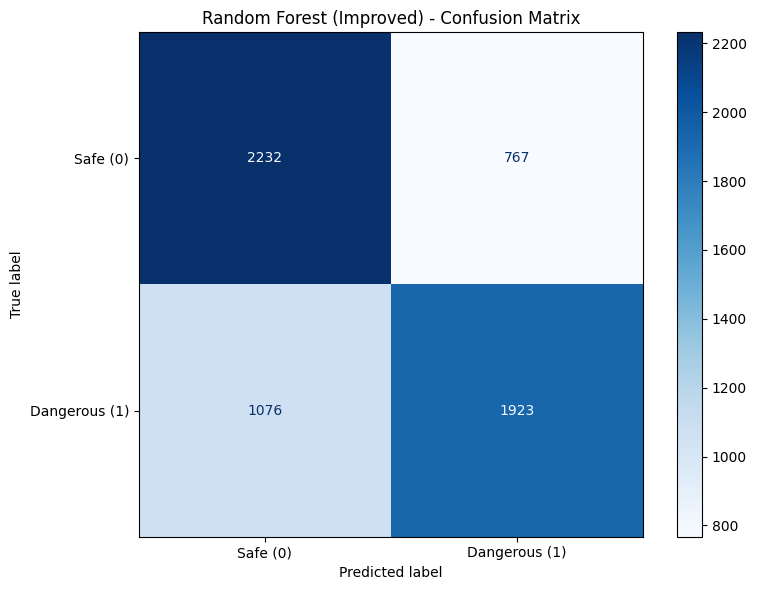

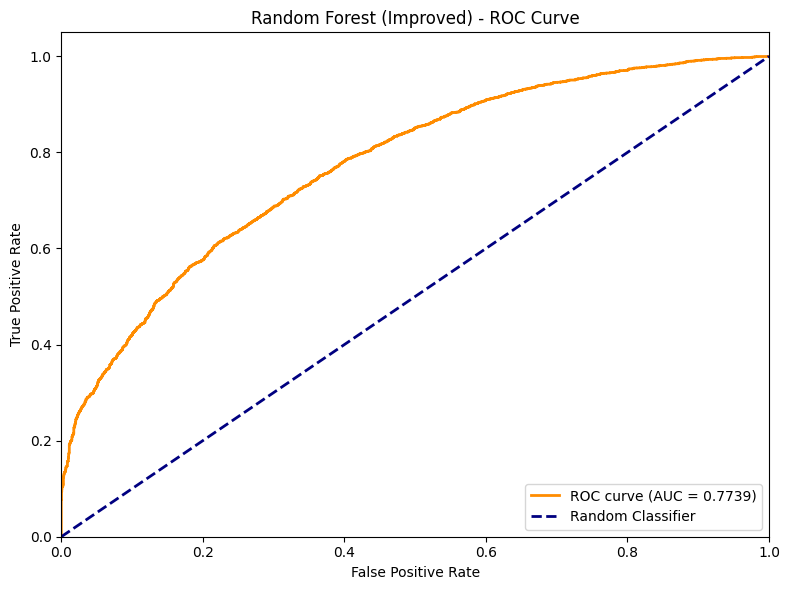


Generating learning history (this may take a moment)...


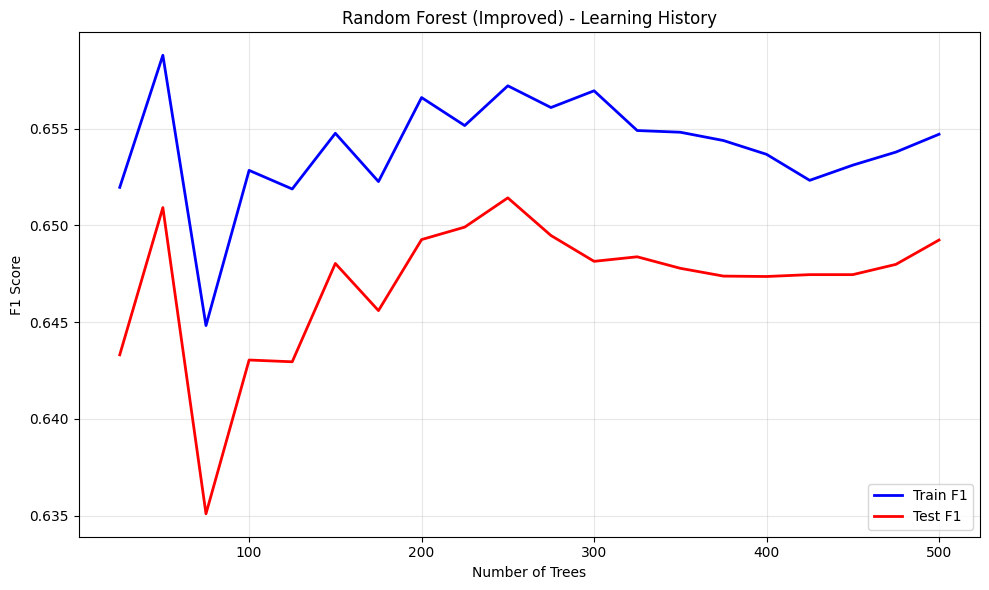

2026/01/31 17:50:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: 7b30bcf2941241f992d9a1f1ff58284a
🏃 View run RandomForest_Improved at: http://localhost:5000/#/experiments/10/runs/7b30bcf2941241f992d9a1f1ff58284a
🧪 View experiment at: http://localhost:5000/#/experiments/10


In [24]:
# Train improved model
with mlflow.start_run(run_name="RandomForest_Improved"):
    # Log parameters
    mlflow.log_params(rf_improved.get_params())
    mlflow.log_param("regularization", "enhanced")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("preprocessing", "variance_threshold")
    mlflow.log_param("n_features", X_train_var.shape[1])
    mlflow.log_param("n_train_samples", X_train_var.shape[0])
    
    # Convert to DataFrame with feature names for improved model
    X_train_var_df = pd.DataFrame(X_train_var, columns=selected_features)
    X_test_var_df = pd.DataFrame(X_test_var, columns=selected_features)
    
    # Train model
    print("Training improved Random Forest...")
    rf_improved.fit(X_train_var_df, y_train)
    
    # Evaluate
    metrics_improved, y_pred_improved, y_proba_improved = evaluate_model(
        rf_improved, X_train_var_df, X_test_var_df, y_train, y_test, 
        model_name="Random Forest (Improved)"
    )
    
    # Log OOB score
    print(f"\nOut-of-Bag Score: {rf_improved.oob_score_:.4f}")
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_improved['train_accuracy'],
        'test_accuracy': metrics_improved['test_accuracy'],
        'train_f1': metrics_improved['train_f1'],
        'test_f1': metrics_improved['test_f1'],
        'precision': metrics_improved['precision'],
        'recall': metrics_improved['recall'],
        'roc_auc': metrics_improved['roc_auc'],
        'overfit_gap': metrics_improved['overfit_gap'],
        'oob_score': rf_improved.oob_score_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_improved, "Random Forest (Improved)")
    mlflow.log_figure(fig_cm, "confusion_matrix_improved.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_improved, "Random Forest (Improved)")
    mlflow.log_figure(fig_roc, "roc_curve_improved.png")
    plt.show()
    
    # Plot and log learning history (F1 vs number of trees)
    print("\nGenerating learning history (this may take a moment)...")
    fig_lh = plot_learning_history_rf(rf_improved, X_train_var_df, y_train, X_test_var_df, y_test, "Random Forest (Improved)")
    mlflow.log_figure(fig_lh, "learning_history_improved.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_var_df, y_train)
    mlflow.sklearn.log_model(rf_improved, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [25]:
# Classification Report for improved model
print("\nClassification Report (Improved):")
print(classification_report(y_test, y_pred_improved, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (Improved):
               precision    recall  f1-score   support

     Safe (0)       0.67      0.74      0.71      2999
Dangerous (1)       0.71      0.64      0.68      2999

     accuracy                           0.69      5998
    macro avg       0.69      0.69      0.69      5998
 weighted avg       0.69      0.69      0.69      5998



---
## 10. Model Comparison Summary

In [26]:
# Summary comparison of all models
comparison_df = pd.DataFrame({
    'Model': ['Random Forest (No Reg)', 'Random Forest (Regularized)', 'Random Forest (Improved)'],
    'Train F1': [metrics_noreg['train_f1'], metrics_reg['train_f1'], metrics_improved['train_f1']],
    'Test F1': [metrics_noreg['test_f1'], metrics_reg['test_f1'], metrics_improved['test_f1']],
    'Precision': [metrics_noreg['precision'], metrics_reg['precision'], metrics_improved['precision']],
    'Recall': [metrics_noreg['recall'], metrics_reg['recall'], metrics_improved['recall']],
    'ROC-AUC': [metrics_noreg['roc_auc'], metrics_reg['roc_auc'], metrics_improved['roc_auc']],
    'Overfit Gap': [metrics_noreg['overfit_gap'], metrics_reg['overfit_gap'], metrics_improved['overfit_gap']]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# Highlight best model
best_idx = comparison_df['Test F1'].idxmax()
print(f"\n🏆 Best Model by Test F1: {comparison_df.loc[best_idx, 'Model']} (F1: {comparison_df.loc[best_idx, 'Test F1']:.4f})")


MODEL COMPARISON SUMMARY
                      Model  Train F1  Test F1  Precision   Recall  ROC-AUC  Overfit Gap
     Random Forest (No Reg)  0.839104 0.769418   0.805323 0.736579 0.860425     0.069686
Random Forest (Regularized)  0.721556 0.705448   0.745819 0.669223 0.801398     0.016108
   Random Forest (Improved)  0.688954 0.676041   0.714870 0.641214 0.773942     0.012913

🏆 Best Model by Test F1: Random Forest (No Reg) (F1: 0.7694)


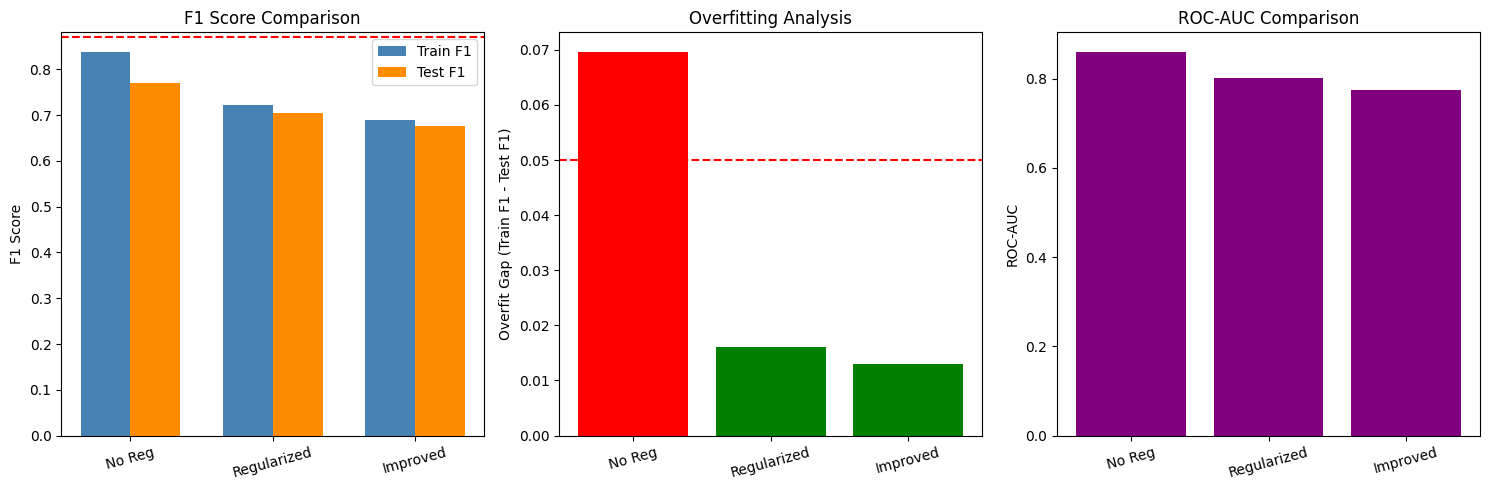

In [27]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# F1 Score comparison
x = range(len(comparison_df))
width = 0.35
axes[0].bar([i - width/2 for i in x], comparison_df['Train F1'], width, label='Train F1', color='steelblue')
axes[0].bar([i + width/2 for i in x], comparison_df['Test F1'], width, label='Test F1', color='darkorange')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score Comparison')
axes[0].legend()
axes[0].axhline(y=0.87, color='red', linestyle='--', label='Target Min')

# Overfit gap
colors = ['red' if gap > 0.05 else 'green' for gap in comparison_df['Overfit Gap']]
axes[1].bar(x, comparison_df['Overfit Gap'], color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[1].set_ylabel('Overfit Gap (Train F1 - Test F1)')
axes[1].set_title('Overfitting Analysis')
axes[1].axhline(y=0.05, color='red', linestyle='--', label='Overfit Threshold')

# ROC-AUC comparison
axes[2].bar(x, comparison_df['ROC-AUC'], color='purple')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[2].set_ylabel('ROC-AUC')
axes[2].set_title('ROC-AUC Comparison')

plt.tight_layout()
plt.show()

---
## 11. Hyperparameter Tuning

Perform hyperparameter tuning on the best model from ablation study using RandomizedSearchCV for efficiency.

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import time

# Determine best base model for tuning
base_models = {
    'noreg': (rf_noreg, metrics_noreg, 'No Regularization'),
    'reg': (rf_reg, metrics_reg, 'Regularized'),
    'improved': (rf_improved, metrics_improved, 'Improved')
}

best_base_name = max(base_models.keys(), key=lambda k: base_models[k][1]['test_f1'])
best_base_model, best_base_metrics, best_base_label = base_models[best_base_name]

print(f"Best base model for tuning: Random Forest ({best_base_label})")
print(f"Current Test F1: {best_base_metrics['test_f1']:.4f}")
print(f"Current Overfit Gap: {best_base_metrics['overfit_gap']:.4f}")

Best base model for tuning: Random Forest (No Regularization)
Current Test F1: 0.7694
Current Overfit Gap: 0.0697


In [29]:
# Define hyperparameter search space for Random Forest
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': randint(50, 200),
    'min_impurity_decrease': uniform(0, 0.01),
    'max_samples': uniform(0.6, 0.4)  # 0.6 to 1.0
}

# Create base model for tuning
rf_tune = RandomForestClassifier(
    class_weight='balanced',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

print("Hyperparameter Search Space:")
for param, dist in param_distributions.items():
    print(f"  {param}: {dist}")

Hyperparameter Search Space:
  n_estimators: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AE022B96C0>
  max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AE0000A470>
  min_samples_split: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AE0002D870>
  min_samples_leaf: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AE022C8880>
  max_features: ['sqrt', 'log2', None]
  max_leaf_nodes: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AE03711030>
  min_impurity_decrease: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AE00009F30>
  max_samples: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AE0000B940>


In [30]:
# Set experiment for hyperparameter tuning
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_tuned")

# Perform randomized search
print("\nStarting Hyperparameter Tuning (this may take several minutes)...")
print("="*60)

start_time = time.time()

random_search = RandomizedSearchCV(
    estimator=rf_tune,
    param_distributions=param_distributions,
    n_iter=30,  # Number of parameter combinations to try
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_scaled, y_train)

tuning_time = time.time() - start_time
print(f"\nTuning completed in {tuning_time/60:.2f} minutes")
print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 Score: {random_search.best_score_:.4f}")

2026/01/31 17:50:14 INFO mlflow.tracking.fluent: Experiment with name 'RandomForest_balanced_smote_tuned' does not exist. Creating a new experiment.



Starting Hyperparameter Tuning (this may take several minutes)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Tuning completed in 14.08 minutes

Best parameters found:
  max_depth: 15
  max_features: sqrt
  max_leaf_nodes: 153
  max_samples: 0.842571623863836
  min_impurity_decrease: 9.197051616629647e-05
  min_samples_leaf: 9
  min_samples_split: 4
  n_estimators: 252

Best CV F1 Score: 0.7618



Random Forest (Tuned) Evaluation Results

Accuracy  - Train: 0.8266 | Test: 0.7739
F1 Score  - Train: 0.8193 | Test: 0.7633
Precision: 0.8010
Recall:    0.7289
ROC-AUC:   0.8557

Overfit Gap (Train F1 - Test F1): 0.0560
⚠️  WARNING: Model shows signs of overfitting!

Out-of-Bag Score: 0.7717


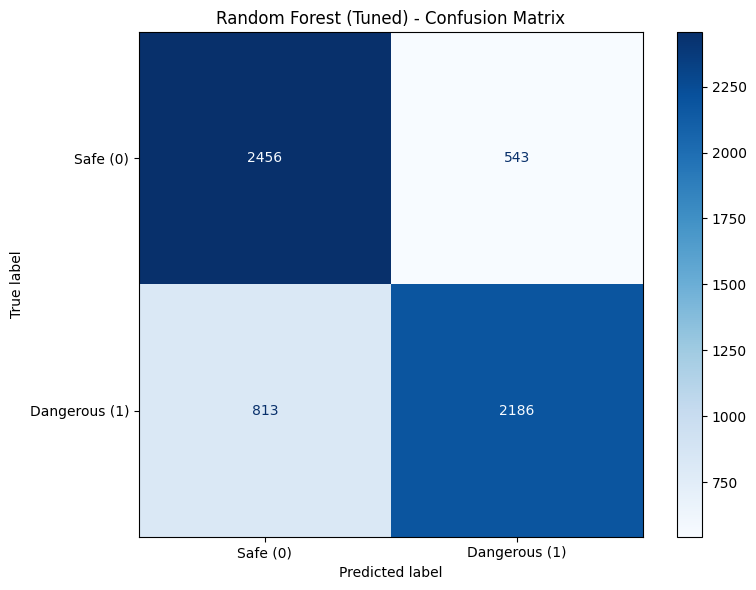

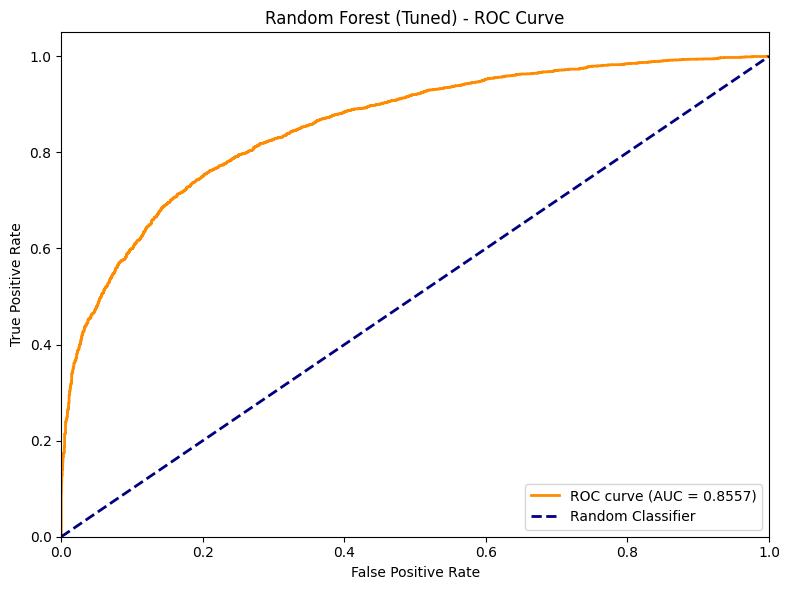

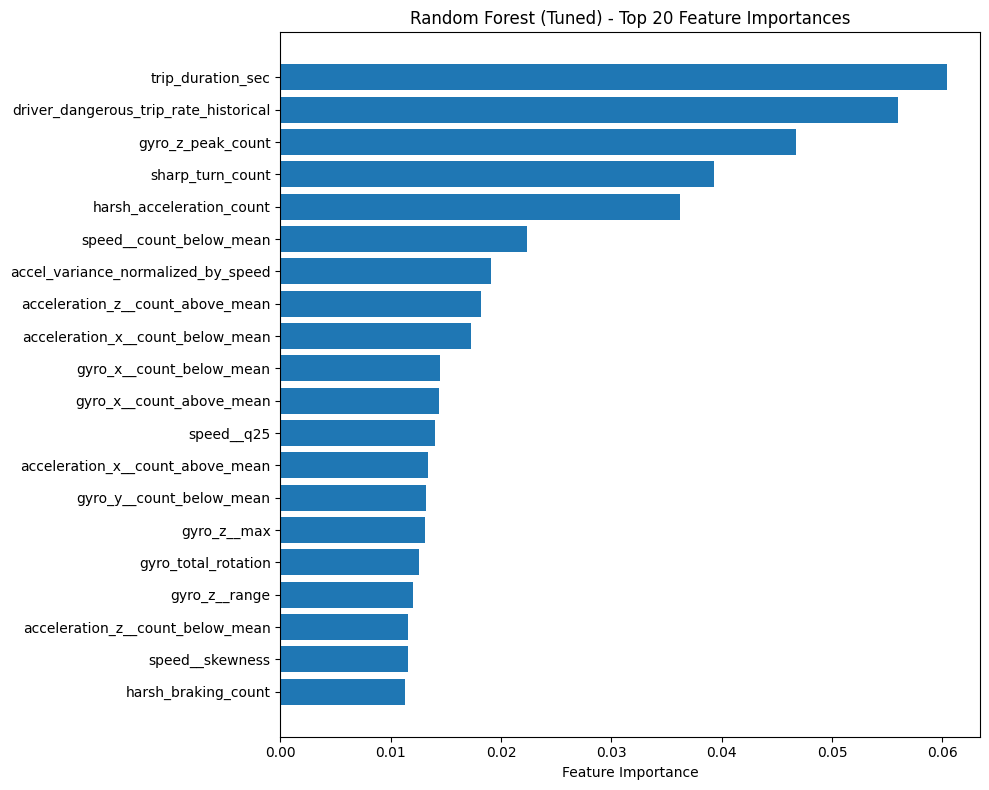

2026/01/31 18:04:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Tuned model logged to MLflow with ID: 99f4d02034704437b5eebf702b86c49e
🏃 View run RandomForest_Tuned at: http://localhost:5000/#/experiments/20/runs/99f4d02034704437b5eebf702b86c49e
🧪 View experiment at: http://localhost:5000/#/experiments/20


In [31]:
# Evaluate tuned model
rf_tuned = random_search.best_estimator_

with mlflow.start_run(run_name="RandomForest_Tuned"):
    # Log best parameters
    mlflow.log_params(random_search.best_params_)
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("n_iter", 30)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("tuning_time_minutes", round(tuning_time/60, 2))
    
    # Evaluate tuned model
    metrics_tuned, y_pred_tuned, y_proba_tuned = evaluate_model(
        rf_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="Random Forest (Tuned)"
    )
    
    # Log OOB score if available
    if hasattr(rf_tuned, 'oob_score_'):
        print(f"\nOut-of-Bag Score: {rf_tuned.oob_score_:.4f}")
        mlflow.log_metric('oob_score', rf_tuned.oob_score_)
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_tuned['train_accuracy'],
        'test_accuracy': metrics_tuned['test_accuracy'],
        'train_f1': metrics_tuned['train_f1'],
        'test_f1': metrics_tuned['test_f1'],
        'precision': metrics_tuned['precision'],
        'recall': metrics_tuned['recall'],
        'roc_auc': metrics_tuned['roc_auc'],
        'overfit_gap': metrics_tuned['overfit_gap'],
        'cv_best_f1': random_search.best_score_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_tuned, "Random Forest (Tuned)")
    mlflow.log_figure(fig_cm, "confusion_matrix_tuned.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_tuned, "Random Forest (Tuned)")
    mlflow.log_figure(fig_roc, "roc_curve_tuned.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(rf_tuned, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="Random Forest (Tuned)")
    mlflow.log_figure(fig_fi, "feature_importance_tuned.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.sklearn.log_model(rf_tuned, "model", signature=signature)
    
    print(f"\n✅ Tuned model logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [32]:
# Compare tuned model with best base model
print("\n" + "="*70)
print("TUNING COMPARISON: Best Base Model vs Tuned Model")
print("="*70)

comparison_tuning = pd.DataFrame({
    'Model': [f'Random Forest ({best_base_label})', 'Random Forest (Tuned)'],
    'Train F1': [best_base_metrics['train_f1'], metrics_tuned['train_f1']],
    'Test F1': [best_base_metrics['test_f1'], metrics_tuned['test_f1']],
    'ROC-AUC': [best_base_metrics['roc_auc'], metrics_tuned['roc_auc']],
    'Overfit Gap': [best_base_metrics['overfit_gap'], metrics_tuned['overfit_gap']]
})

print(comparison_tuning.to_string(index=False))

# Calculate improvement
f1_improvement = metrics_tuned['test_f1'] - best_base_metrics['test_f1']
overfit_improvement = best_base_metrics['overfit_gap'] - metrics_tuned['overfit_gap']

print(f"\n📊 Improvement Summary:")
print(f"   F1 Score Change: {f1_improvement:+.4f} ({'✅ Improved' if f1_improvement > 0 else '❌ No improvement'})")
print(f"   Overfit Gap Change: {overfit_improvement:+.4f} ({'✅ Less overfitting' if overfit_improvement > 0 else '⚠️ More overfitting'})")

# Determine final best model
TUNING_IMPROVED = metrics_tuned['test_f1'] > best_base_metrics['test_f1']
if TUNING_IMPROVED:
    print(f"\n🏆 Tuned model is better! Will save tuned model.")
else:
    print(f"\n📌 Base model ({best_base_label}) is better or equal. Will save base model.")


TUNING COMPARISON: Best Base Model vs Tuned Model
                            Model  Train F1  Test F1  ROC-AUC  Overfit Gap
Random Forest (No Regularization)  0.839104 0.769418 0.860425     0.069686
            Random Forest (Tuned)  0.819299 0.763268 0.855661     0.056031

📊 Improvement Summary:
   F1 Score Change: -0.0062 (❌ No improvement)
   Overfit Gap Change: +0.0137 (✅ Less overfitting)

📌 Base model (No Regularization) is better or equal. Will save base model.


---
## 12. Save Best Model

In [33]:
import joblib
import os

# Create models directory
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Determine best model (including tuned)
models = {
    'noreg': (rf_noreg, metrics_noreg),
    'reg': (rf_reg, metrics_reg),
    'improved': (rf_improved, metrics_improved),
    'tuned': (rf_tuned, metrics_tuned)
}

best_model_name = max(models.keys(), key=lambda k: models[k][1]['test_f1'])
best_model, best_metrics = models[best_model_name]

# Save the best model
model_path = os.path.join(models_dir, 'randomforest_best_model.joblib')
joblib.dump(best_model, model_path)

# Save the scaler
scaler_path = os.path.join(models_dir, 'randomforest_scaler.joblib')
joblib.dump(scaler, scaler_path)

print(f"Best model saved: {model_path}")
print(f"Scaler saved: {scaler_path}")
print(f"\nBest Model: Random Forest ({best_model_name})")
print(f"Test F1 Score: {best_metrics['test_f1']:.4f}")
print(f"Overfit Gap: {best_metrics['overfit_gap']:.4f}")

Best model saved: ../models\randomforest_best_model.joblib
Scaler saved: ../models\randomforest_scaler.joblib

Best Model: Random Forest (noreg)
Test F1 Score: 0.7694
Overfit Gap: 0.0697


---
## Summary

This notebook trained Random Forest models for dangerous driving detection with:

1. **No Regularization (Baseline)**: High complexity model to establish baseline and identify overfitting
2. **With Regularization**: Applied tree depth limits, min samples constraints, and leaf node limits
3. **Improved Model**: Enhanced preprocessing and optimized hyperparameters for better F1 score

### Key Findings:
- Class imbalance handled using `class_weight='balanced'` and `balanced_subsample`
- Regularization through tree constraints reduced overfitting
- OOB score provides additional validation metric
- All experiments tracked in MLflow for comparison

### Next Steps:
- Compare with other models (XGBoost, LightGBM, etc.)
- Run hyperparameter tuning if needed
- Deploy best model for production